In [1]:
import sounddevice as sd
import torchaudio
import torch
import matplotlib.pyplot as plt
from transformer_model import TransformerModel

/Users/juliushietala/opt/anaconda3/envs/junction20/lib/python3.9/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
batch_size = 1
bptt = 80

ntoken_embedding = None #len(TEXT.vocab.stoi) # the size of vocabulary # AMOUNT OF COMMANDS
embedding_size = 24 # embedding dimension
nhid = 256 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 6 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8 # the number of heads in the multiheadattention models
dropout = 0.2
    
model = TransformerModel(ntoken_embedding, embedding_size, nhead, nhid, nlayers, n_outputs=30, ready_embedding=True, dropout=0.2, bptt=bptt)
model.load_state_dict(torch.load("/Users/juliushietala/junction_2020/junction-2020-gubbet-koodaa/speech_recognition/transformer/best_model_eval_100noise.mdl", map_location=torch.device('cpu')))
src_mask = model.generate_square_subsequent_mask(80)

myrec (16000, 1)


/Users/juliushietala/opt/anaconda3/envs/junction20/lib/python3.9/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)


unknown


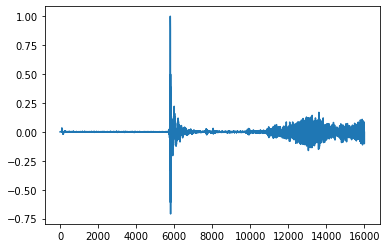

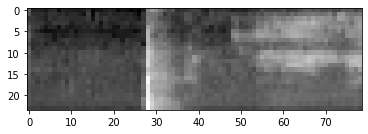

In [3]:
duration = 1  # seconds
fs = 44100
fs = 48000
fs = 16000
myrecording = sd.rec(duration*fs, dtype='int16', samplerate=fs, channels=1)
sd.wait()
print("myrec", myrecording.shape)
sd.play(myrecording, samplerate=fs)
waveform = torch.tensor(myrecording, dtype=torch.float32)
#print(at.size())
plt.plot(waveform.numpy()/torch.max(waveform));
waveform = waveform.t() / torch.max(waveform)
sample_rate = fs
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0
#hamming, hanning, povey (default), rectangular, blackman
params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": True,
    "round_to_power_of_two": True,
    "sample_frequency": sample_rate,
    "num_mel_bins": 24
}

fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

#print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray');
data = torch.zeros((80,24))
data[:79,:] = fbank
data = data.view((80,1,24))
pred = model(data, src_mask)
pred_idx = torch.argmax(pred)
desired_labels = ['up', "down", "left", "right", "unknown"]
print(desired_labels[pred_idx])

In [8]:
import sounddevice as sd
import numpy as np
import time
from IPython.display import clear_output
window = np.zeros((15000, 1))
start_np = np.zeros(1)
np_flag = np.array([False])
    
def callback(indata, frames, time, status):

    
    window[:5000,:] = window[5000:10000,:]
    window[5000:10000,:] = window[10000:15000,:]
    window[10000:15000,:] = indata

    if np.max(indata) > 7000 and not np_flag[0]:
        np_flag[0] = True
        waveform = torch.tensor(window, dtype=torch.float32)
        waveform = waveform.t() / torch.max(waveform)
        fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)
        data = torch.zeros((80,24))
        data[:fbank.shape[0],:] = fbank
        data = data.view((80,1,24))
        pred = model(data, src_mask)
        pred_idx = torch.argmax(pred)
        desired_labels = ['up', "down", "left", "right", "unknown"]
        clear_output(wait=True)
        print(desired_labels[pred_idx])
    else:
        np_flag[0] = False


with sd.InputStream(channels=1, dtype='int16', blocksize=5000, samplerate=fs, callback=callback):
    sd.sleep(1000000)


left


KeyboardInterrupt: 